In [6]:
import json 
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def evaluate_and_plot_mlp(
    model_path: str,
    norms_json: str,
    hidden_dims: list[int],
    activations: list[str],
    test_csv: str,
    sample_index: int = None,
    include_ratio_features: bool = True
):
    """
    Load a trained 2-output MLP, apply saved norms, and evaluate on test data.

    Args:
      model_path: path to .pth
      norms_json: path to norms json
      hidden_dims, activations: network spec
      test_csv: path to test CSV
      sample_index: optional index to highlight
      include_ratio_features: if False, drop the two per-GPI features
    """
    # 0) Load norms
    with open(norms_json, 'r') as f:
        norms = json.load(f)
    y_mean = np.array(norms['y_mean'], dtype=np.float32)
    y_std  = np.array(norms['y_std'],  dtype=np.float32)
    feat_mean = norms['x_mean']  # dict of all numeric features
    feat_std  = norms['x_std']

    # 1) Load test data
    df = pd.read_csv(test_csv)
    output_cols = df.columns[:2].tolist()
    y_true = df[output_cols].to_numpy(dtype=np.float32)

    # 2) Determine numeric inputs, optionally dropping ratio cols
    numeric_inputs = list(feat_mean.keys())
    if not include_ratio_features:
        numeric_inputs = [
            c for c in numeric_inputs
            if c not in ('Proppant.per.GPI..lb.ft.', 'Fluid.per.GPI..gal.ft.')
        ]

    # normalize numeric
    df_num = df[numeric_inputs].astype(float).copy()
    for c in numeric_inputs:
        df_num[c] = (df_num[c] - feat_mean[c]) / feat_std[c]

    # 3) One-hot encode last categorical
    cat_col = df.columns[-1]
    df_dum = pd.get_dummies(df[cat_col], prefix=cat_col)

    # 4) Build feature matrix, align columns
    feature_names = numeric_inputs + df_dum.columns.tolist()
    X_full = pd.concat([df_num, df_dum], axis=1)
    X = X_full.reindex(columns=feature_names, fill_value=0)
    X_np = X.to_numpy(dtype=np.float32)

    # 5) Define MLP architecture
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations, out_dim):
            super().__init__()
            layers, dims = [], [in_dim] + hidden_dims
            for i, h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if   act=='relu':     layers.append(nn.ReLU())
                elif act=='tanh':     layers.append(nn.Tanh())
                elif act=='sigmoid':  layers.append(nn.Sigmoid())
                elif act=='softplus': layers.append(nn.Softplus())
                else: raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], out_dim))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x)

    # 6) Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(
        in_dim      = X_np.shape[1],
        hidden_dims = hidden_dims,
        activations = activations,
        out_dim     = y_true.shape[1]
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 7) Predict & un-normalize
    with torch.no_grad():
        y_pred_norm = model(torch.from_numpy(X_np).to(device)).cpu().numpy()
    y_pred = y_pred_norm * y_std + y_mean

    # 8) Compute & print R² only for output1
    r2_1 = r2_score(y_true[:,0], y_pred[:,0])
    print(f"R² (output1): {r2_1:.4f}")

    # 9) Error histogram for output1
    errs = y_pred[:,0] - y_true[:,0]
    plt.figure(figsize=(8,5))
    plt.hist(errs, bins=30, edgecolor='k')
    plt.title("Output1 Error Histogram")
    plt.xlabel("Predicted − True")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 10) True vs Pred scatter for output1
    plt.figure(figsize=(6,6))
    plt.scatter(y_true[:,0], y_pred[:,0], alpha=0.6)
    mn, mx = min(y_true[:,0].min(), y_pred[:,0].min()), max(y_true[:,0].max(), y_pred[:,0].max())
    plt.plot([mn,mx],[mn,mx],'k--')
    if sample_index is not None and 0 <= sample_index < len(y_true):
        plt.scatter(
            y_true[sample_index,0],
            y_pred[sample_index,0],
            color='red', s=80,
            label=f"Sample {sample_index}"
        )
        plt.legend()
    plt.title("Output1 True vs Pred")
    plt.xlabel("True Output1")
    plt.ylabel("Predicted Output1")
    plt.tight_layout()
    plt.show()


In [7]:
sample_index = 1

# relu

R² (output1): 0.7824


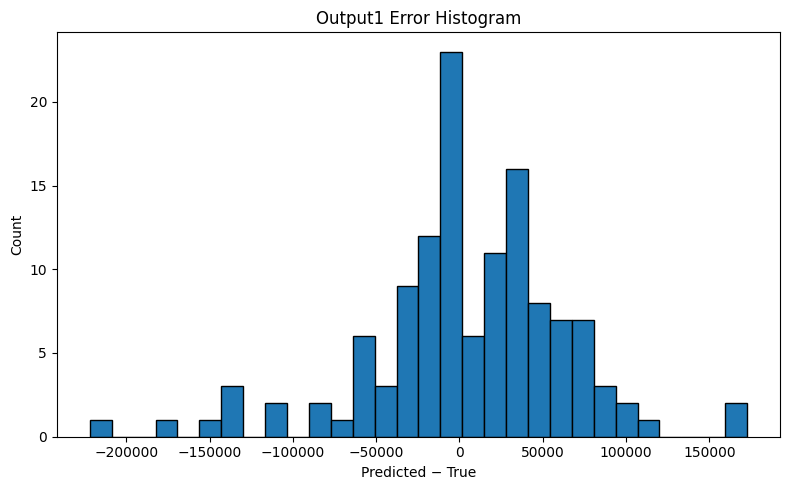

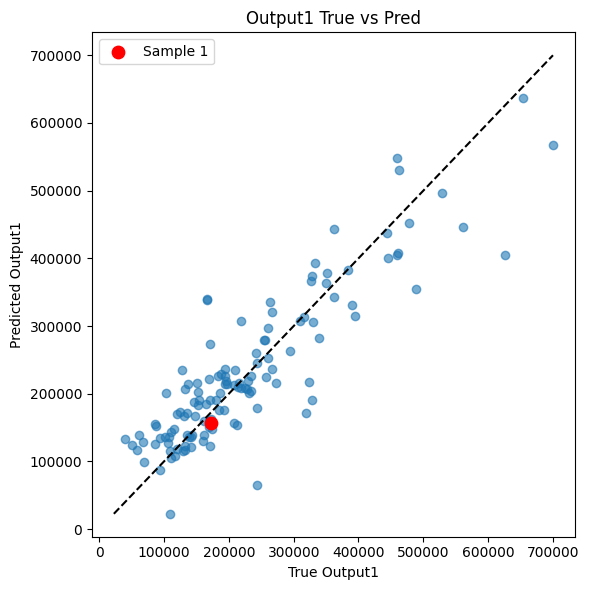

In [8]:
evaluate_and_plot_mlp(
    model_path   = "/home/kamiar/chevron/Eagle-Ford/Second/d3feed88/d3feed88_fold1.pth",
    norms_json   = "/home/kamiar/chevron/Eagle-Ford/Second/d3feed88/d3feed88_norms.json",
    hidden_dims  = [64, 256],
    activations  = ['tanh', 'relu'],
    test_csv     = "/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    include_ratio_features = True
)

# softplus

R² (output1): 0.7536


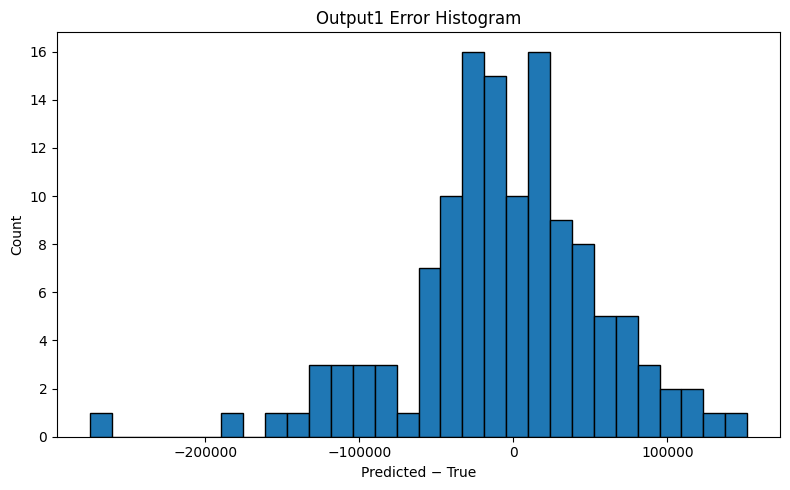

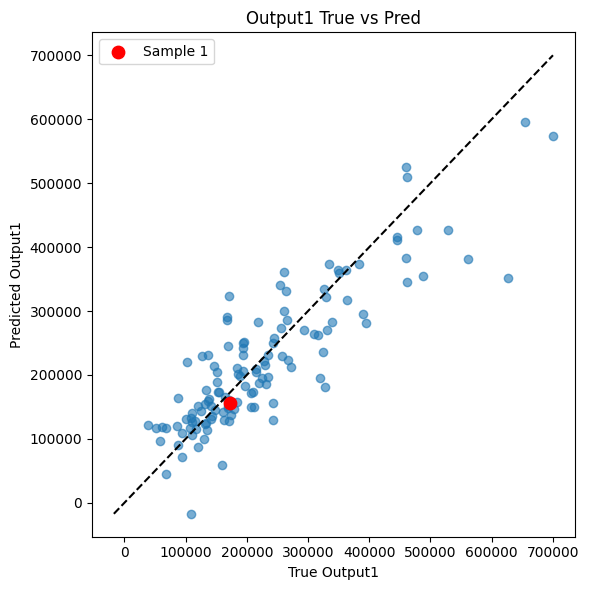

In [9]:
evaluate_and_plot_mlp(
    model_path   = "/home/kamiar/chevron/Eagle-Ford/Second/4eb5e823/4eb5e823_fold1.pth",
    norms_json   = "/home/kamiar/chevron/Eagle-Ford/Second/4eb5e823/4eb5e823_norms.json",
    hidden_dims  = [64, 256],
    activations  = ['tanh', 'softplus'],
    test_csv     = "/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    include_ratio_features = True
)

# relu rdundatn reemoved

R² (output1): 0.7813


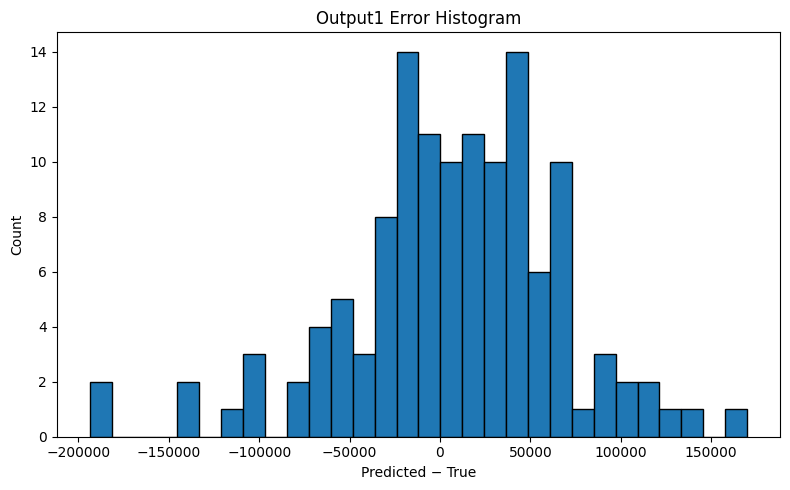

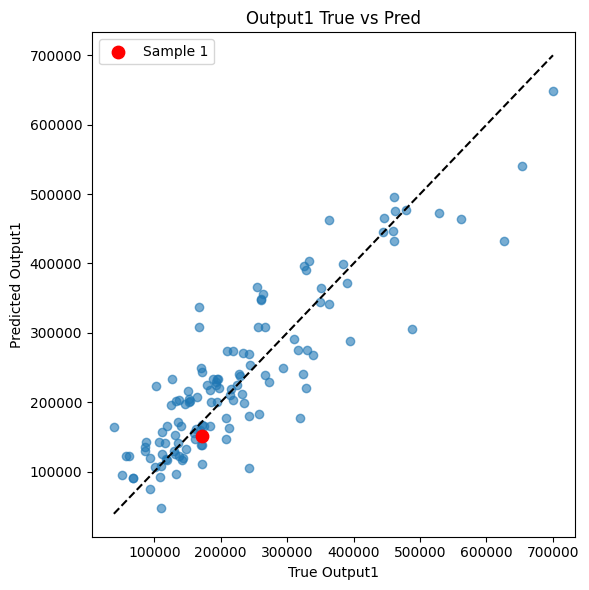

In [10]:
evaluate_and_plot_mlp(
    model_path   = "/home/kamiar/chevron/Eagle-Ford/Second/5044f3a3/5044f3a3_fold6.pth",
    norms_json   = "/home/kamiar/chevron/Eagle-Ford/Second/5044f3a3/5044f3a3_norms.json",
    hidden_dims  = [64, 256],
    activations  = ['tanh', 'relu'],
    test_csv     = "/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    include_ratio_features = False
)

# redundatn removed softplus

R² (output1): 0.7408


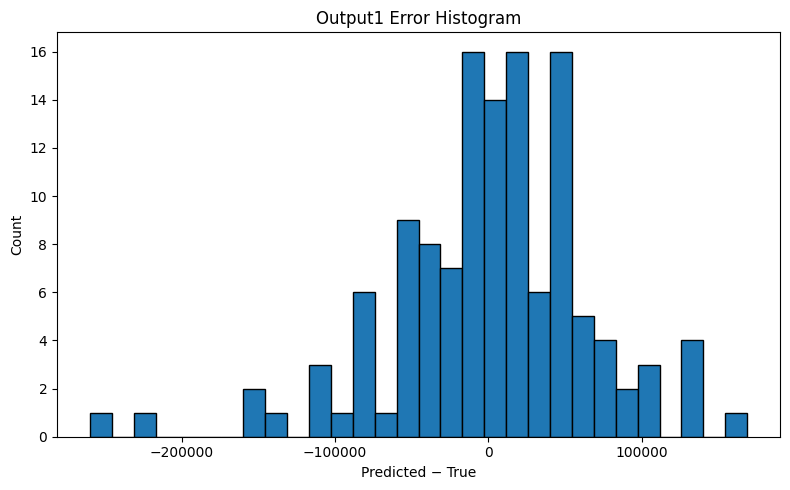

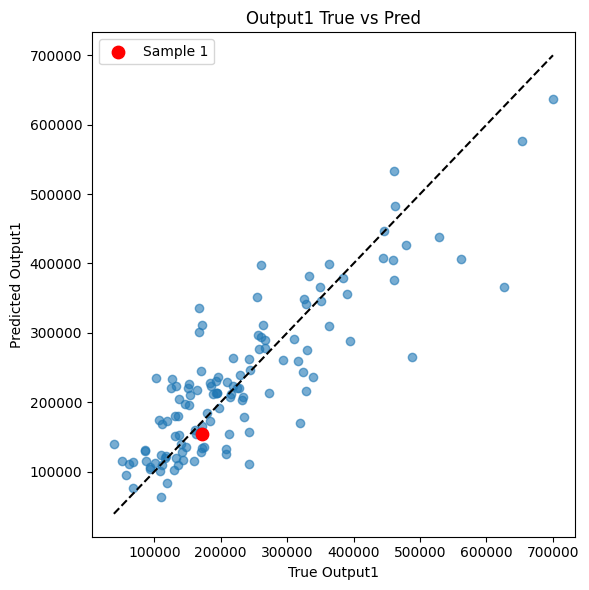

In [11]:
evaluate_and_plot_mlp(
    model_path   = "/home/kamiar/chevron/Eagle-Ford/Second/98a1fcb5/98a1fcb5_fold6.pth",
    norms_json   = "/home/kamiar/chevron/Eagle-Ford/Second/98a1fcb5/98a1fcb5_norms.json",
    hidden_dims  = [64, 256],
    activations  = ['tanh', 'softplus'],
    test_csv     = "/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_test.csv",
    sample_index = sample_index,
    include_ratio_features = False
)